In [2]:
# Step the environment
import os
import shutil
import torch
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from AdEMAMix import AdEMAMix
# Constants
from stable_baselines3 import SAC, PPO
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize

mu = 398600 # km^3/s^2
R_E = 6378

eps = np.finfo(np.float32).eps.item()

log_dir = './runs/experiment_1'

# Remove the log directory if it exists
# if os.path.exists(log_dir):
    # shutil.rmtree(log_dir)

# writer = SummaryWriter(log_dir=log_dir)

In [3]:
# Helper functions
def v_orb(h):
        return np.sqrt(mu / (h + R_E))

def intersect_ray_sphere(P, u, x0, r):
    """
    Determines the intersections of a ray with a sphere.
    
    Parameters:
    P (numpy array): The starting point of the ray (3D vector).
    u (numpy array): The direction of the ray (3D vector).
    x0 (numpy array): The center of the sphere (3D vector).
    r (float): The radius of the sphere.
    
    Returns:
    t1, t2 (float, float): The parameter values at which the intersections occur.
    None if there are no intersections.
    """
    # Normalize direction vector
    u = u / np.linalg.norm(u)
    
    # Compute coefficients of the quadratic equation
    A = np.dot(u, u)
    B = 2 * np.dot(u, P - x0)
    C = np.dot(P - x0, P - x0) - r**2
    
    # Compute the discriminant
    discriminant = B**2 - 4*A*C
    
    if discriminant < 0:
        # No intersection
        return None
    elif discriminant == 0:
        # One intersection (tangent)
        t = -B / (2*A)
        return (P + t * u,)
    else:
        # Two intersections
        sqrt_disc = np.sqrt(discriminant)
        t1 = (-B + sqrt_disc) / (2*A)
        t2 = (-B - sqrt_disc) / (2*A)
        return (P + t1 * u, P + t2 * u, t1, t2)
    
def earth_line_intersection(P, u):
    p = intersect_ray_sphere(P, u, np.array([0, 0, -R_E]), R_E)
    if(p is None):
        return p
    else:
        p1, p2, t1, t2 = p
        if(t1 < 0 and t2 < 0):
            return (p1, p2)
        else:
            return None
        
def qdot_matrix(q):
    qw, qx, qy, qz = q
    return np.array([
        [-qx, -qy, -qz],
        [qw, -qz, qy],
        [qz, qw, -qx],
        [-qy, qx, qw]
    ])

def qdot(q, w):
    return 0.5 * qdot_matrix(q) @ w

def euler_eqn(w, u, J, Jinv):
    return Jinv @ (u - np.cross(w, J @ w))

def xdot(x, u, J, Jinv):
    w = x[:3]
    q = x[3:]

    w_dot = euler_eqn(w, u, J, Jinv)
    q_dot = qdot(q, w)

    return np.concatenate([w_dot, q_dot])

def q2mat(q, homogenous=False):
    w, x, y, z = q
    if(not homogenous):
        return np.array([
            [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
            [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
            [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
        ])
    return np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w, 0],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w, 0],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2, 0],
        [0, 0, 0, 1]
    ])

def eul2q(yaw, pitch, roll):
    # Calculate the half angles
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)

    # Calculate the quaternion
    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy

    return (w, x, y, z)

def eul2R(roll, pitch, yaw):
    
    # Calculate rotation matrix for roll (around x-axis)
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])
    
    # Calculate rotation matrix for pitch (around y-axis)
    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Calculate rotation matrix for yaw (around z-axis)
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])
    
    # Combine the rotations
    R = R_z @ (R_y @ R_x)
    
    return R

def get_intrinsics(f, c_x, c_y):
    K = np.hstack([np.array([-f, 0, c_x, 0, -f, c_y, 0, 0, 1]).reshape(3,3), np.zeros((3,1))])
    return K

def get_extrinsics(q, p):
    R_q = q2mat(q)
    R_0 = eul2R(0, np.pi, -np.pi/2) # boresight on -z
    R = R_q @ R_0
    t = -R @ p
    bottom_row = np.array([[0, 0, 0, 1]])
    Rt = np.concatenate((R, t.reshape(3, 1)), axis=1)
    transformation_matrix = np.concatenate((Rt, bottom_row), axis=0)
    return transformation_matrix

def get_camera_matrix(K, q, p):
    return K @ get_extrinsics(q, p)

def task_from_track(across, along):
    theta = along / R_E
    phi = across / R_E

    return np.array([R_E * np.sin(theta), R_E * np.cos(theta) * np.sin(phi), R_E * (np.cos(theta) * np.cos(phi) - 1)])

def get_model_weights_norm(model):
    """
    Calculate the norm of the weights of a PyTorch model.

    Args:
    model (nn.Module): The PyTorch model.

    Returns:
    float: The norm of the weights.
    """
    total_norm = 0.0
    for param in model.parameters():
        param_norm = param.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    
    return total_norm

def get_model_grad_norm(model):
    """
    Calculate the norm of the gradients of a PyTorch model.

    Args:
    model (nn.Module): The PyTorch model.

    Returns:
    float: The norm of the gradients.
    """
    total_norm = 0.0
    for param in model.parameters():
        param_norm = param.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    
    return total_norm

In [111]:

class TaskingEnv(gym.Env):
    def __init__(self, h = 400, field_of_regard=20, dt=0.1, umax = 0.1, J = np.eye(3), x0 = np.array([0, 0, 0, 1, 0, 0, 0]), f=1600, width=1200, height=800):
        
        self.t = 0
        self.dt = dt
        self.h = h
        self.umax = umax
        self.x = x0
        self.x0 = x0
        # self.tasks = [task_from_track(0, 0)]
        self.v = v_orb(h)
        self.K = get_intrinsics(f, width/2, height/2)
        # Track velocity
        v_t = self.v * (1 - (h/R_E))
        self.spin_rate = v_t / R_E
        self.J = J
        self.Jinv = np.linalg.inv(self.J)
        self.width = width
        self.height = height
        self.field_of_regard = field_of_regard

        self.tasks = [task_from_track((np.random.rand(1) * 2 - 1) * self.h * np.sin(np.deg2rad(field_of_regard)), np.random.rand(1) * 200 + 50) for i in range(7)]
        self.horizon_distance = np.sqrt((R_E + h)**2 - R_E**2)

        self.tasks_covered = np.zeros((len(self.tasks),))
        self.action_space = spaces.Box(low=np.array([-self.umax, -self.umax, -self.umax, -100, -100]), high=np.array([self.umax, self.umax, self.umax, 100, 100]), shape=(5,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(39,), dtype=np.float32)
    
    def step_dynamics(self, x, u):
        k1 = self.dt * xdot(x, u, self.J, self.Jinv)
        k2 = self.dt * xdot(x + 0.5 * k1, u, self.J, self.Jinv)
        k3 = self.dt * xdot(x + 0.5 * k2, u, self.J, self.Jinv)
        k4 = self.dt * xdot(x + k3, u, self.J, self.Jinv)

        return x + (k1 + 2*k2 + 2*k3 + k4) / 6

    def step_tasks(self, x, t):
        # Rotate the tasks
        R = eul2R(0, -self.spin_rate * t, 0)
        x_0 = np.array([[0, 0, R_E]]).T
        return R @ (x + x_0) - x_0

    def step(self, action): 
        # Split torques and cameras...
        # u, c = np.split(action, 3)
        u = action[:3]
        c = np.argmax(action[3:])
        
        w = self.x[:3]
        q = self.x[3:]
        self.t += self.dt
        self.x = self.step_dynamics(self.x, u)
        tasks = [self.step_tasks(x, self.t) for x in self.tasks]

        terminated = False
        truncated = False

        # observation = dynamics, tasks, covered tasks

        # Rewards from camera coverage
        # Check which tasks are covered
        reward = 0.0
        total_covers = 0
        
        P = get_camera_matrix(self.K, q, np.array([0, 0, self.h]))
        base_reward = 0
        camera_tracks = []

        for i, task in enumerate(tasks):
            base_reward += 1000.0 * self.h/np.linalg.norm(task - np.array([0.0, 0.0, self.h]))
            x_cam = P @ np.concatenate([task, np.array([[1]])])
            offset = x_cam[2].copy()
            x_cam /= offset

            camera_tracks.append(x_cam)
            base_reward *= 2
            # if(c):
                # base_reward *= 2

            if(c and x_cam[0] > 0 and x_cam[0] < self.width and x_cam[1] > 0 and x_cam[1] < self.height and self.tasks_covered[i]==0 and np.linalg.norm(task - np.array([0.0, 0.0, self.h]))< self.horizon_distance):
                self.tasks_covered[i] = 1
                total_covers += 1
            else:
                if(c):
                    reward -= 1000
                    
        reward += base_reward * (total_covers ** 1.5)
        # reward -= 0.01 * (u[0:3]**2).sum() * self.dt
        reward -= 0.01 * (w**2).sum() * self.dt

        if(self.t > 10):
            terminated = True
        
        intersection = earth_line_intersection(np.array([0, 0, self.h]), q2mat(q) @ np.array([0, 0, 1]))
        if(intersection == None):
            intersection = np.array([-1, -1, -1])
            reward -= self.horizon_distance * self.dt
        else:
            intersection = intersection[0]
            reward -= 0.3 * np.sqrt((intersection ** 2).sum()) * self.dt
            # print(torch.sqrt((intersection ** 2).sum()))

        # Generate observation
        obs = np.concatenate([self.x, np.array([self.t]), np.stack(self.tasks).flatten(), intersection, self.tasks_covered])
        
        return obs, reward, terminated, truncated, {"camera_track": camera_tracks}
    

    def reset(self, seed=None, options=None):
        self.x = self.x0  
        self.tasks = [task_from_track((np.random.rand(1) * 2 - 1) * self.h * np.sin(np.deg2rad(self.field_of_regard)), np.random.rand(1) * 200 + 50) for i in range(7)]
        self.tasks_covered = np.zeros(len(self.tasks))
        self.t = 0
        intersection = earth_line_intersection(np.array([0, 0, self.h]), q2mat(self.x[3:]) @ np.array([0, 0, 1]))
        if(intersection == None):
            intersection = np.array([-1, -1, -1])
        else:
            intersection = intersection[0]

        return np.concatenate([self.x, np.array([self.t]), np.stack(self.tasks).flatten(), intersection, self.tasks_covered]), {}


In [140]:
env = TaskingEnv()
env = RecordEpisodeStatistics(env)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, training=True, norm_obs=True, norm_reward=True)

# env.step(np.array([0, 0, 0]))
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=log_dir, ent_coef=0.02, gamma=1, gae_lambda=0.95)
# model = SAC('MlpPolicy', env, verbose=1, tensorboard_log=log_dir)
model.learn(total_timesteps=1000000)

Using cpu device
Logging to ./runs/experiment_1\PPO_33


c:\Users\shree\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\shree\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 3.86e+05 |
| time/              |          |
|    fps             | 1205     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_mean          | 3.19e+05    |
| time/                   |             |
|    fps                  | 865         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012138955 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.12       |
|    explained_variance   | 0.138       |
|    learning_rate        | 0.

In [165]:
# Evaluate and get a list of states

states = []
camera_tracks = []
tasks = None

state = env.reset()
for i in tqdm(range(100)):
    action, _ = model.predict(state, deterministic=True)
    state, _, dones, infos = env.step(action)
    if(action[0, -1] >= action[0, -2]):
        camera_tracks.append(infos[0]["camera_track"])
        print(f"Camera at {i}")
    states.append(env.get_original_obs()[0])

print(len(camera_tracks))
# Plot the ground track


100%|██████████| 100/100 [00:00<00:00, 1498.75it/s]

Camera at 23
1


1


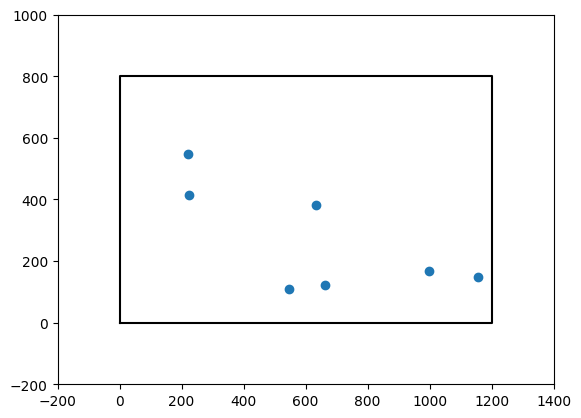

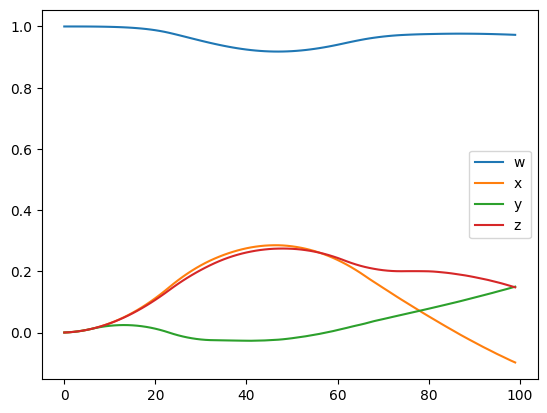

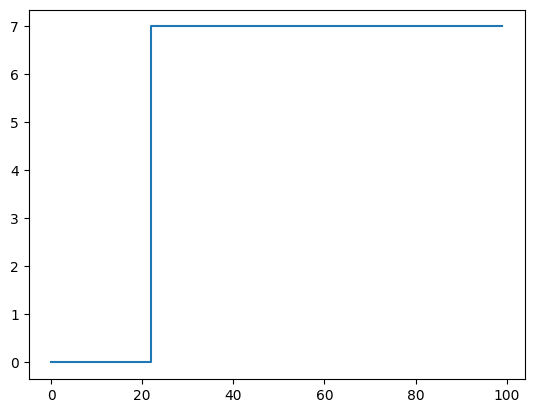

In [166]:
print(len(camera_tracks))
import matplotlib.pyplot as plt

for c in camera_tracks:
    plt.plot([x[0] for x in c], [x[1] for x in c], 'o')

# Plot the bounding box
raw_env = env.venv.envs[0].env
plt.plot([0, raw_env.width, raw_env.width, 0, 0], [0, 0, raw_env.height, raw_env.height, 0], 'k')
plt.xlim(-200, raw_env.width + 200)
plt.ylim(-200, raw_env.height + 200)
plt.show()

# Quaternion plot
states = np.array(states)
plt.plot(states[:, 3], label='w')
plt.plot(states[:, 4], label='x')
plt.plot(states[:, 5], label='y')
plt.plot(states[:, 6], label='z')
plt.legend()
plt.show()

# Tasks covered
plt.step(range(100), np.sum(states[:, -7:], axis=1))
plt.show()

